# **Notebook3**
## **Feature Management**

## **Table of Contents**

* [1. Introduction](#1.)

* [2. Importing](#2)
    * [2.1 Importing Libraries](#2.1)
    * [2.2 Importing Datasets](#2.2)

* [3. Data Exploration and Treatment](#3.)
    * [3.1. Feature Engineering](#3.1.)

     * [2.2.1 Numerical Data](#2.2.1)
    * [2.2.2 Categorical Data](#2.2.2)
    * [2.3 Feature Engineering](#2.3)
    * [2.4 Data Partitioning](#2.4)
    * [2.5 Encoding](#2.5)
    * [2.6 Scaling](#2.6)


## **1. Introduction**
This notebook executes the core **Feature Engineering** phase by performing two critical operations: splitting the data and applying statistical transformations in a controlled, non-leaking sequence. Since we are **not using a Scikit-learn Pipeline**, all transformation steps (Imputation, Scaling, Encoding) must be manually fitted and applied.

### Anti-Leakage Protocol: Split First
1.  **Split Data First:** The structurally cleaned dataset is first divided into dedicated Training, Validation, and Test sets.
2.  **Fit on Training Only:** All statistical transformers (`SimpleImputer`, `StandardScaler`, `OneHotEncoder`) are then **fitted exclusively on the Training set**.
3.  **Transform All:** The parameters learned solely from the Training set are applied to transform the Training, Validation, and Test sets.

This explicit, manual sequencing guarantees that no information from the Test or Validation set contaminates the Training process.

### Objectives
The objectives are:
* **Data Splitting:** Divide the dataset into 60% Training, 20% Validation, and 20% Test sets using a stratified approach to maintain class balance (`OK`/`KO`) in all partitions.
* **Imputation:** Manually fit and transform the data, filling missing values in numerical features using the median calculated only from the Training data.
* **Scaling:** Manually fit and transform the numerical features using the `StandardScaler`, with its mean ($\mu$) and standard deviation ($\sigma$) calculated only from the Training data.
* **Encoding:** Manually fit and transform the categorical feature (`origin`) using `OneHotEncoder` based only on the unique categories present in the Training data.
* **Export:** Save the fully transformed data splits and the fitted transformer objects for direct use by the **Modelling (NB4)** and **Final Model (NB9)** notebooks.

## **2. Importing Section**

### **2.1. Importing Libraries**

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import pickle, os
import matplotlib.pyplot as plt
import seaborn as sns

# Data partitioning
from sklearn.model_selection import train_test_split, StratifiedKFold 

# Imputation
from sklearn.impute import SimpleImputer

# Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Scaling methods
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#Model Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
import scipy.stats as stats

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### **2.2. Importing the Learn and Predict Dataset**

In [2]:
'''Loading the cleaned learning dataset'''
learn_clean = pd.read_csv('datasetlearn_cleaned.csv', sep = ',', index_col = 0) #The reference to index_col=0 is to avoid the creation of an extra index column which would cause issues later on
display(learn_clean.shape)
learn_clean.head()

(5199, 16)

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,origin,oven_temperature,pastry_type,preheating_time,salt_ratio,sugar_content,vanilla_extract,quality_class_binary
id,,,,,,,,,,,,,,,,
1,54.0,24.0,26.0,100.4,52.0,11.0,309.0,3.2,Lisboa,NaN,Pastel de Nata,207.0,42.74,22.8,5.7,0
2,66.0,37.0,34.0,98.0,46.0,10.0,317.0,3.3,Lisboa,306.0,NaN,245.0,41.73,11.6,4.0,0
3,41.0,30.0,19.0,99.3,53.0,10.0,130.0,3.4,Porto,121.0,NaN,186.0,75.10,20.3,7.5,1
4,62.0,24.0,48.0,98.0,115.0,9.0,354.0,3.3,Lisboa,357.0,Pastel de Nata,186.0,46.41,73.3,4.2,1
5,55.0,21.0,34.0,100.1,48.0,9.0,211.0,3.0,Lisboa,202.0,Pastel de Nata,218.0,56.52,80.1,6.0,0


&nbsp;&nbsp;&nbsp;&nbsp; The `predict.csv` dataset (unseen data)  needs to go through the same transformations applied previously to the training data. That way, we **guarantee consistency** between all datasets.
The Machine Learning model must receive all the datasets with the **same format**: the same columns on the same scales and with the same categorical encodings used during the training phase.


In [3]:
'''Loading the prediction dataset'''
predict_data = pd.read_csv('Nata_Files/predict.csv', sep = ',', index_col = 0)
display(predict_data.shape)
predict_data.head()

(1300, 16)

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,notes_baker,origin,oven_temperature,pastry_type,preheating_time,salt_ratio,sugar_content,vanilla_extract
id,,,,,,,,,,,,,,,,
5201,79.0,22,40,98.6,79.0,9.0,259.0,3.2,NaN,Lisboa,268.0,NaN,208.0,49.63,182.6,4.0
5202,49.0,26,32,101.9,105.0,9.0,287.0,3.2,NaN,Lisboa,287.0,Pastel de nata,189.0,182.54,76.2,4.8
5203,80.0,28,24,96.6,20.0,10.0,64.0,3.4,NaN,Porto,74.0,Pastel Nata,201.0,100.41,23.5,6.1
5204,74.0,21,37,97.2,81.0,9.0,314.0,3.0,NaN,Lisboa,317.0,NaN,220.0,46.66,143.2,4.9
5205,41.0,19,41,97.3,104.0,10.0,246.0,3.2,NaN,Lisboa,243.0,Pastel Nata,191.0,39.45,143.0,7.0


In [4]:
''' 
We will use the same logic as in notebook 2 to clean the prediction dataset.
Firstly, we will drop the unneeded columns and then get rid of inconsistencies in the 'origin' column
'''
predict_data = predict_data.drop(columns=[ 'notes_baker']) 
predict_data['pastry_type'] = predict_data['pastry_type'].str.strip().str.lower().str.replace('pastel nata', 'pastel de nata').str.title().str.replace(' De ', ' de ')
predict_data['origin'] = predict_data['origin'].str.strip().str.lower().str.title()
print(predict_data['origin'].unique()) #just to check if it worked

['Lisboa' 'Porto' nan]


## **3. Data Exploration and Treatment**

### **3.1. Dealing with Impossible Values**

While analysing our dataset and our features, we found there were some  **physically impossible values** that can represent data entry errors or sensor malfuncstions.

Therefore, we defined the following domain constraints:
1.  **Percentages (Humidity & Fat):** Must be between 0% and 100%.
2.  **pH Scale:** Must be between 0 and 14.
3.  **Physical Dimensions (Time/Temp):** Must be non-negative.

**Treatment Strategy:**

Instead of dropping these rows, as we would lose valuable information, we **convert these 'errors' to `NaN`** (Missing Values). These will be handled later on.

**Note:** In cases where values exceeded the constrained limits, capping them at those thresholds would introduce a larger error compared to median imputation. Additionally, capping would create an artificial 'spike' in the data at those thresholds, distorting the feature's distribution.

In [5]:
'''
In the descriptive statistics of notebook 1, we verified that there were no negative number in the dataset. 
Therefore, we will not check for impossible values for that constraint.
'''
# 1st Constraint: Percentages (0 to 100)
impossible_humidityL = learn_clean[(learn_clean['ambient_humidity'] > 100) | (learn_clean['ambient_humidity'] < 0)]
impossible_fatL = learn_clean[(learn_clean['cream_fat_content'] > 100) | (learn_clean['cream_fat_content'] < 0)]

impossible_humidityP = predict_data[(predict_data['ambient_humidity'] > 100) | (predict_data['ambient_humidity'] < 0)]
impossible_fatP = predict_data[(predict_data['cream_fat_content'] > 100) | (predict_data['cream_fat_content'] < 0)]

# 2nd Constraint: pH Scale (0 to 14)
impossible_phL = learn_clean[(learn_clean['lemon_zest_ph'] > 14) | (learn_clean['lemon_zest_ph'] < 0)]
impossible_phP = predict_data[(predict_data['lemon_zest_ph'] > 14) | (predict_data['lemon_zest_ph'] < 0)]

print(f"Impossible Humidity rows in learn_clean: {len(impossible_humidityL)}")
print(f"Impossible Humidity rows in predict_data: {len(impossible_humidityP)}")

print(f"Impossible Fat rows: {len(impossible_fatL)}")
print(f"Impossible Fat rows in predict_data: {len(impossible_fatP)}")

print(f"Impossible pH rows: {len(impossible_phL)}")
print(f"Impossible pH rows in predict_data: {len(impossible_phP)}")

Impossible Humidity rows in learn_clean: 0
Impossible Humidity rows in predict_data: 0
Impossible Fat rows: 1099
Impossible Fat rows in predict_data: 281
Impossible pH rows: 0
Impossible pH rows in predict_data: 0


In [6]:
'''
We will just replace the values in cream fat content as it is the only feature with impossible values found (in both datasets).
'''
learn_clean.loc[impossible_fatL.index, 'cream_fat_content'] = np.nan
predict_data.loc[impossible_fatP.index, 'cream_fat_content'] = np.nan

### **3.2. Feature Engineering**

&nbsp;&nbsp;&nbsp;&nbsp;To better capture the interaction between ingredients and the baking process, we decided to **create two new features**.

* **`sugar_fat_ratio`**:
    This captures the relative proportion of two key ingredients: `sugar_content` and `cream_fat_content`. A small constant ($1e^{-6}$) was added to prevent errors due to divison by zero in cases where fat content might be zero or missing. 

    
* **`baking_intensity`**:
    By multiplying `baking_duration` by `oven_temperature`, we are able to quantify the overall heat exposure the product underwent during the baking process. This allows the model to dstinguish between a 'short but high' heat and a 'long but low' heat.



In [7]:
'''These transformations were applied consistently to both the training and prediction datasets, for the reasons already stated.'''

#Original Dataset
learn_clean['sugar_fat_ratio'] = learn_clean['sugar_content'] / (learn_clean['cream_fat_content'] + 1e-6)  # the small constant to avoid division by zero
learn_clean['baking_intensity'] = learn_clean['baking_duration'] * learn_clean['oven_temperature']

#Predict Dataset
predict_data['sugar_fat_ratio'] = predict_data['sugar_content'] / (predict_data['cream_fat_content'] + 1e-6)
predict_data['baking_intensity'] = predict_data['baking_duration'] * predict_data['oven_temperature']

### **3.3. Data Partitioning**

In this section, we basically separate the **features (X)** from the **target variable (Y)** and split the dataset into **3 different subsets**. We opted for a Train-Validation-Test split rather than a simple Train-Test split to avoid **Data Leakage** during model optimization.

Since `scikit-learn` does not support a 3-way split, we performed two different splits to achieve a **70% / 15% / 15%** distribution:
1. **First Split:** We divided the data into **Training (70%)** and a temporary "Rest" set (30%).
2.  **Second Split:** We split the "Rest" set equally (50/50) to create the **Validation (15%)** and **Test (15%)** sets.

**Parameters Used:**
* `stratify=y`: Ensures the proportion of 'OK' and 'KO' Pastéis de Nata is identical across all three sets.
* `random_state=42`: Guarantees reproducibility of the split.
* `shuffle = True`: It mixes the rows randomly before cutting it.

In [8]:
X = learn_clean.drop('quality_class_binary',axis = 1) #features
y = learn_clean['quality_class_binary'] #target

In [9]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size = 0.7,shuffle = True, random_state=42, stratify=y) #70% train, 30% rest

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle = True, random_state=42, stratify=y_rest) #15% val, 15% test

In [10]:
print('train:{}% | validation:{}% | test:{}%'.format(round(len(y_train)/len(y),2),
                                                     round(len(y_val)/len(y),2),
                                                     round(len(y_test)/len(y),2)
                                                    ))

train:0.7% | validation:0.15% | test:0.15%


### **3.3.1. Separate Numerical and Categorical**

As different data types requires different and specific trasnformations, we separated them into **Numeric** and **Categorical**. We applied this separation consistently across all partitions (Train, Validation, Test) and also the unlabelled Prediction set (`predict_data`).

In [11]:
numerical_features = X.select_dtypes(include = np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude = np.number).columns.tolist()

In [12]:
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['ambient_humidity', 'baking_duration', 'cooling_period', 'cream_fat_content', 'egg_temperature', 'egg_yolk_count', 'final_temperature', 'lemon_zest_ph', 'oven_temperature', 'preheating_time', 'salt_ratio', 'sugar_content', 'vanilla_extract', 'sugar_fat_ratio', 'baking_intensity']
Categorical Features: ['origin', 'pastry_type']


In [13]:
#NUMERICAL FEATURES
X_train_num = X_train.select_dtypes(include = np.number)
X_val_num = X_val.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

X_predict_num = predict_data.select_dtypes(include = np.number)

In [14]:
#CATEGORICAL FEATURES
X_train_cat = X_train.select_dtypes(exclude = np.number)
X_val_cat = X_val.select_dtypes(exclude = np.number)
X_test_cat = X_test.select_dtypes(exclude = np.number)

X_predict_cat = predict_data.select_dtypes(exclude = np.number)

### **3.4. Imputation of Missing Values**

To address missing values (including the "impossible" values converted to `NaN` during the cleaning phase), we implemented a **Median Imputation** strategy for the numerical and a **Mode Imputation** to the categorical. We chose the median over the mean because it provides a more representative central value as it is **robust to outliers**.

In [15]:
'''
The imputer was fitted only on the training set to prevent Data Leakage
This strictly ensures that no information from the evaluation sets leaks into the training process.
'''

imputer = SimpleImputer(strategy='median')
imputer.fit(X_train_num)

imputer2 = SimpleImputer(strategy='most_frequent')
imputer2.fit(X_train_cat)

,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [16]:
#NUMERICAL FEATURES
#  Transform all splits using the median learned from the training data
X_train_num.loc[:, :] = imputer.transform(X_train_num) 
X_val_num.loc[:, :] = imputer.transform(X_val_num)
X_test_num.loc[:, :] = imputer.transform(X_test_num)

X_predict_num.loc[:, :] = imputer.transform(X_predict_num)

#CATEGORICAL FEATURES
#  Transform all splits using the most frequent value learned from the training data
X_train_cat.loc[:, :] = imputer2.transform(X_train_cat)
X_val_cat.loc[:, :] = imputer2.transform(X_val_cat)
X_test_cat.loc[:, :] = imputer2.transform(X_test_cat)   

X_predict_cat.loc[:, :] = imputer2.transform(X_predict_cat)

### **3.5. Encoding Categorical Features**

We utilized the `OneHotEncoder` to transform categorical data into a machine readable format. We created binary columns for each category (e.g. `origin_Lisboa`, `origin_Porto`)

**Parameters Used:**
- `handle_unknown ='ignore'`:  If the Test or Prediction set contains a category label **never seen** during training, the encoder will output **zero** instead of crashing.
- `sparse_output= False`: it forces the econder to return a format that can easily be transformed in a DataFrame.

In [17]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 
#if an unseen category appears in the test or prediction data, the encoder will ignore it.

encoder.fit(X_train_cat) #Once again, only fitting on training data to avoid Data Leakage

#Training Data
X_train_cat_encoded = encoder.transform(X_train_cat)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_train_cat.index)

#Validation Data
X_val_cat_encoded = encoder.transform(X_val_cat)
X_val_cat_encoded = pd.DataFrame(X_val_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_val_cat.index)

#Testing Data
X_test_cat_encoded = encoder.transform(X_test_cat)  
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_test_cat.index)

#Prediction Data
X_predict_cat_encoded = encoder.transform(X_predict_cat)
X_predict_cat_encoded = pd.DataFrame(X_predict_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_predict_cat.index)

### **3.6. Feature Scaling**

Since our dataset has outliers, we chose **RobustScaler** which ensures that the majority of our data is scaled to a standard range without being distorted by the few extreme values

In [18]:
scaler = RobustScaler()


#Fitting the scaler ONLY on the training data
scaler.fit(X_train_num)

#Transforming training data
X_train_scaled = scaler.transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_features, index = X_train_num.index)

#Transforming validation data
X_val_scaled = scaler.transform(X_val_num)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = numerical_features, index = X_val_num.index)

#Transforming testing data
X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = numerical_features, index = X_test_num.index)

#Transforming prediction data
X_predict_scaled = scaler.transform(X_predict_num[numerical_features])
X_predict_scaled = pd.DataFrame(X_predict_scaled, columns = numerical_features, index = X_predict_num.index)

### **Prepare for Feature Selection and Modelling**

To prepare for **Feature Selection and Modeling**, we merged the processed numerical and categorical features into a unified dataset. 

In the Feature Selection part we must have a view of how **ALL** the variables are related to each other and how important to the classification they are. Models like Lasso and RFE do not choose the 'best numerical' or 'best categorical' in isolation but instead in general.

In [19]:
#TRAIN
X_train_final = pd.concat([X_train_scaled, X_train_cat_encoded], axis=1)

#VALIDATION
X_val_final = pd.concat([X_val_scaled, X_val_cat_encoded], axis=1)

#TEST
X_test_final = pd.concat([X_test_scaled, X_test_cat_encoded], axis=1)

#PREDICTION
X_predict_final = pd.concat([X_predict_scaled, X_predict_cat_encoded], axis=1)

## **4. Feature Selection**

With the dataset fully processed and unified into `X_train_final`, we now turn our attention to identifying the most relevant predictors for determining tart quality.

The objective of this phase is to reduce the dimension of the dataset by filtering out features that are **irrelevant, redundant, or non-informative**. 

The Methods we decided to use were:
* **Filter Methods:** Variance Thresholding and Spearman's Correlation;
* **Wrapper Methods:** Recursive Feature Elimination (RFE);
* **Embedded Methods:** Lasso Regression and Decision Trees.

### **4.1. Filter Methods**

**4.1.1. Low Variance Variables Filter**

We will analyse the variance of each feature to identify "constant" variables (variance approximately equal to zero). Features with variance near zero carry almost no information, as they do not vary across different samples.

## PORQUE É QUE ISTO MUDOU O NOME DA VARIAVEL

In [35]:
X_train_final.var().sort_values()

pastry_type_Pastel de Nata    0.000000
origin_Lisboa                 0.177893
egg_temperature               0.514358
baking_intensity              0.595425
lemon_zest_ph                 0.690131
vanilla_extract               0.764231
baking_duration               0.860913
sugar_fat_ratio               0.861861
cooling_period                1.073395
egg_yolk_count                1.548949
salt_ratio                    1.634721
dtype: float64

 We can observe that the variable `pastry_type` has a variance of zero, which means it's a constant and, therefore, can be removed from the dataset.
 All the other features exhibit relatively **significant variance (> 0.1)**, indicating they have sufficient variability to be potentially useful for the model. 

**Decision:** We will drop that feature.


In [36]:
X_train_final = X_train_final.drop(columns=['pastry_type'], errors='ignore')
X_val_final   = X_val_final.drop(columns=['pastry_type'], errors='ignore')
X_test_final  = X_test_final.drop(columns=['pastry_type'], errors='ignore')
X_predict_final = X_predict_final.drop(columns=['pastry_type'], errors='ignore')

**4.1.2. Spearman's Correlation**

We will now observe the relationships between features using **Spearman's Rank Correlation Coefficient**. We selected this method over the standard Pearson correlation because Spearman evaluates relationships based on rank rather than raw values.

The **primary goal** of this analysis is to identify **multicollinearity** (where 2 features are so strongly correlated that it becomes redundant information).
Additionally, by observing the correlation between each feature and the target variable, we begin to understand which factors might be the important ones to define if the pastéis are 'OK' or 'KO' (**Predictive Power**).

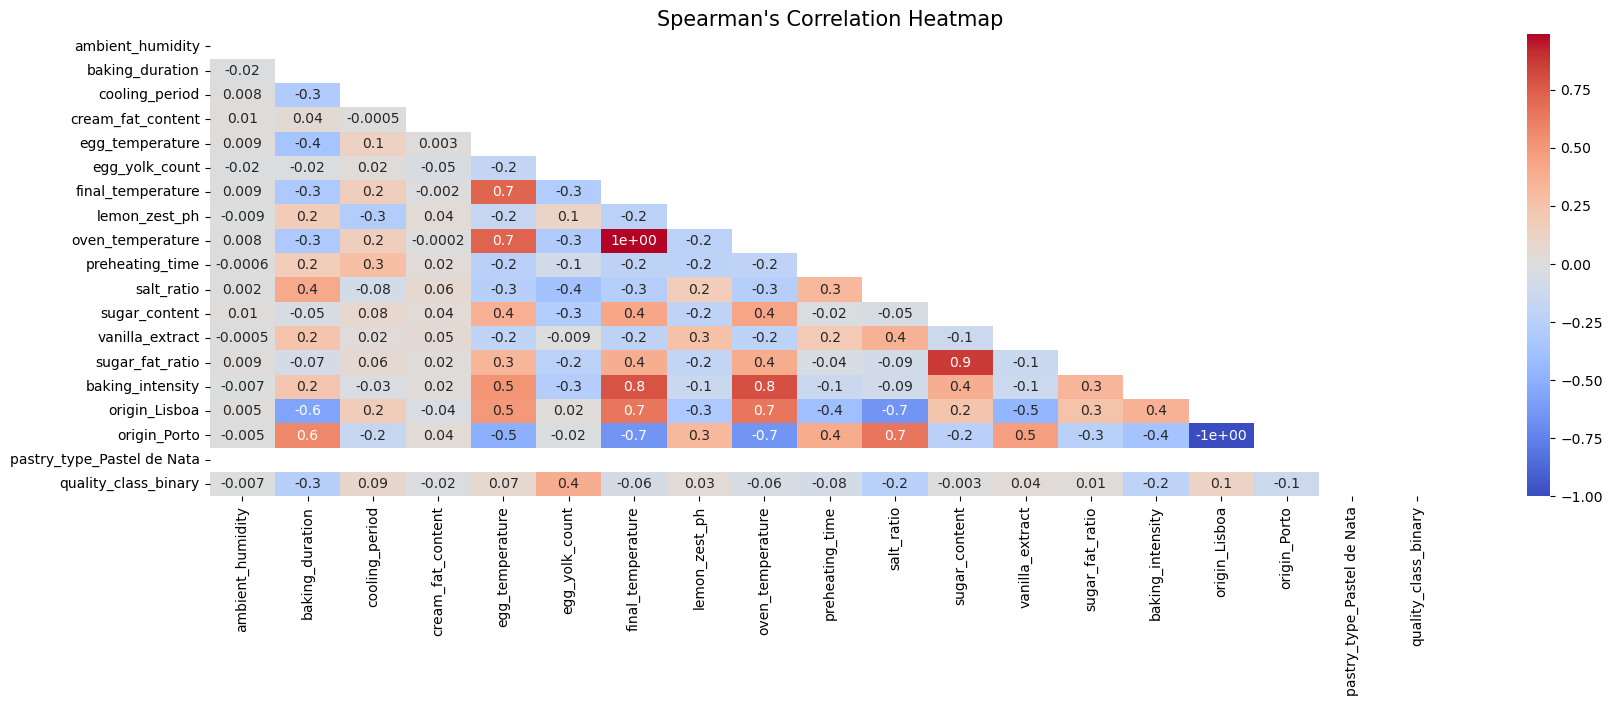

In [22]:
# Temporarily joining the numeric observations with the target
all_train_numerical = X_train_final.join(y_train)

# Computing Spearman's Correlation
correlation = all_train_numerical.corr(method = 'spearman')

# Plotting the lower triangle of the correlation map
def corr_heatmap(correlation):
    plt.figure(figsize=(20, 6))
    ax = sns.heatmap(data = correlation, annot = True, mask = np.triu(np.ones_like(correlation)), cmap = 'coolwarm', fmt = '.1') 
    #the mask= is to show only the lower triangle as the matrix is symmetric and it is easier to read this way
    ax.set_title("Spearman's Correlation Heatmap", fontdict = {'fontsize': 15})
    plt.show()

corr_heatmap(correlation)

**Analysis of Correlation Results:**

The heatmap reveals significant insights into the dataset's structure:

**1. Multicollinearity (Redundant Features):**

We identified several pairs of features with extremely high correlation, indicating they provide duplicate information:

* **`oven_temperature` vs. `final_temperature` (1.0):** These are perfectly correlated. We must **remove one to prevent model instability**.
* **`sugar_fat_ratio` vs. `sugar_content` (0.9):** The engineered feature we created (sugar_fat_ratio) is almost identical to the sugar content itself. Keeping both is redundant.
* **`origin_Lisboa` vs. `origin_Porto` (-0.9):** Strong negative correlation is expected, if a pastél is from Lisbon, it is not from Porto. One should be removed.

**2. Predictive Power (Correlation with Target):**

* **`egg_yolk_count` (0.4):** Positive correlation (More yolks = Better quality?).
* **`baking_duration` (-0.3):** Negative correlation (Longer baking might imply lower quality or burnt tarts).

**Decision:**
To reduce noise and multicollinearity, we will remove `final_temperature` (redundant), `sugar_content` (redundant with ratio), and one of the origin columns.

In [23]:
#we drop immediately because we are SURE these features are not useful
X_train_final = X_train_final.drop(columns=['final_temperature', 'sugar_content', 'origin_Porto'], errors='ignore')
X_val_final   = X_val_final.drop(columns=['final_temperature', 'sugar_content', 'origin_Porto'], errors='ignore')
X_test_final  = X_test_final.drop(columns=['final_temperature', 'sugar_content', 'origin_Porto'], errors='ignore')
X_predict_final = X_predict_final.drop(columns=['final_temperature', 'sugar_content', 'origin_Porto'], errors='ignore')

**4.1.3. Chi Squared**

While Spearman's correlation is effective for numerical features, we require a different statistical test to evaluate our categorical predictors, which in this case is only `origin`. So, we wil analyse the **Chi-Squared, Test of Independence**.

We will basically determin if there is a significant relationship between the categorical feature and the target variable (`quality_class_binary`).

In [24]:
def TestIndependence(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result = "{0} is an IMPORTANT predictor".format(var)
    else:
        result = "{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [25]:
for variable in X_train_cat.columns:
    TestIndependence(X_train_cat[variable], y_train, variable)

origin is an IMPORTANT predictor
pastry_type is NOT an important predictor. (Discard pastry_type from model)


**Analysis of Chi-Squared Results:**

The test results indicate a strong statistical dependency between **`origin`** and the target variable. The origin of the tart (Lisbon vs. Porto vs. Unknown) is **not random** with respect to quality, which means that knowing the origin significantly helps predict whether a tart will be "OK" or "KO".

**Decision:** We will keep the `origin` feature.

### **4.2. Wrapper Methods**

In [26]:
model = LogisticRegression()

**4.2.1 RFE - Recursive Feature Eimination**

Unlike filter methods (which look at features in isolation), **Wrapper Methods** evaluate feature subsets by actually training a model. Now, we will use **Recursive Feature Elimination (RFE)** with a Logistic Regression estimator.

To determine the optimal complexity for our model, the RFE process works like in a validation loop. We tested subsets, training a new model for each subset size and evaluating its performance on the **Validation Set**.
This approach allows us to pinpoint the exact number of features that maximizes predictive accuracy while minimizing noise, effectively letting the model itself decide which variables are important.

In [27]:
# Number of features
nof_list = np.arange(1,8)
high_score = 0

# Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):
    rfe = RFE(model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_final,y_train)
    X_val_rfe = rfe.transform(X_val_final)
    model.fit(X_train_rfe,y_train)

    score = model.score(X_val_rfe,y_val)
    score_list.append(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 4
Score with 4 features: 0.739744


In [28]:
rfe = RFE(estimator = model, n_features_to_select = nof)
rfe_fitted = rfe.fit_transform(X_train_final, y_train)
selected_features = pd.Series(rfe.support_, index = X_train_final.columns)
selected_features

ambient_humidity              False
baking_duration               False
cooling_period                False
cream_fat_content             False
egg_temperature                True
egg_yolk_count                 True
lemon_zest_ph                 False
oven_temperature               True
preheating_time               False
salt_ratio                    False
vanilla_extract               False
sugar_fat_ratio               False
baking_intensity               True
origin_Lisboa                 False
pastry_type_Pastel de Nata    False
dtype: bool

**Analysis of RFE Results:**

The recursive elimination process identified that the model achieves its peak performance on the validation set using a specific subset of features. In this case, its peak was **~0.74%**.

The selected features (listed above) represent the **best** predictors for differentiating between "OK" and "KO" tarts. These features are: `egg_temperature`, `egg_yolk_count`, `oven_temperature` and `baking_intensity`.

### **4.3. Embedded Methods**

 **4.3.1. Lasso**

Lasso forces the coefficients of less important features to be exactly zero. Features that do not appear in the bar chart were defined as **irrelevant** by the model relative to the other features. On the other hand, the features with the longest bars are considered "more important".

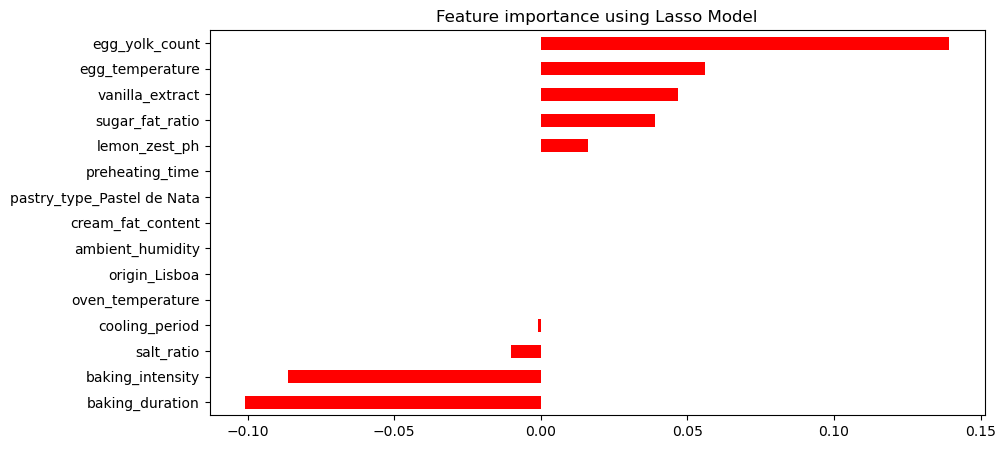

In [29]:
def plot_importance(coef):
    imp_coef = coef.sort_values()
    plt.figure(figsize = (10, 5))
    imp_coef.plot(kind = "barh", color = 'red')
    plt.title("Feature importance using Lasso Model")
    plt.show()

reg = LassoCV()

reg.fit(X_train_final, y_train)

coef = pd.Series(reg.coef_, index = X_train_final.columns)

plot_importance(coef)

**Analysis of Lasso Results:**

The features with coefficient of zero are: `preheating_time`, `cream_fat_content`, `ambient_humidity`, `origin_Lisboa` and `oven_temperature`. The `cooling_period`also has an extremely low importance for the predictions. We will keep this in mind and continue with the analysis.

 **4.3.2. Tree-Based Feature Importance**

 We will now utilize **Decision Trees** to evaluate feature importance from a non-linear perspective. To ensure robustness, we calculated importance using two different criteria: **Gini Impurity** and **Entropy (Information Gain)**. While Gini measures the probability of misclassification, Entropy measures the reduction in chaos.77

 Features appearing at the top of the chart are the most effective at predicting the quality of the pastéis. We expect to see consistency with previous methods.

<Axes: xlabel='Value', ylabel='Features'>

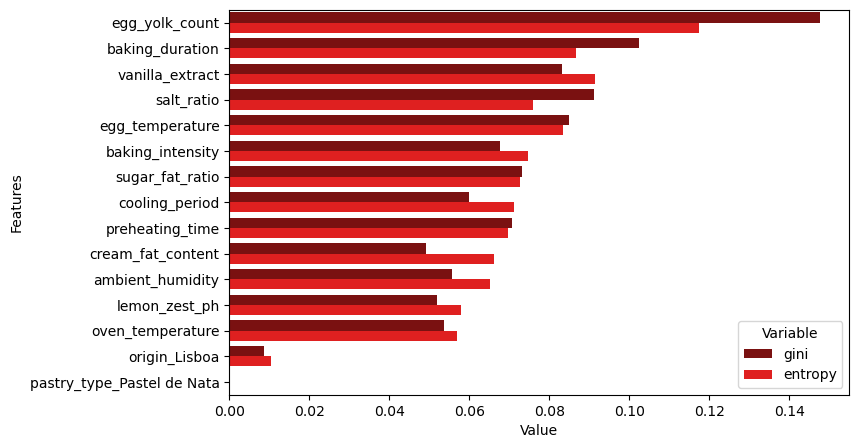

In [30]:
gini_importance = DecisionTreeClassifier(splitter='random', random_state=42).fit(X_train_final, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=42).fit(X_train_final, y_train).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
zippy['Features'] = X_train_final.columns
tidy = zippy.melt(id_vars='Features').rename(columns=str.title)
tidy.sort_values(['Value'], ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(y='Features', x='Value', hue='Variable', data=tidy, palette=['darkred', 'red'])

**Analysis of Tree-Based Results:**

The features that "should be removed" based on this method are: `origin_Lisboa`, `cream_fat_content`, `oven_temperature` and `baking_intensity`.

### **5. Voting Strategy**

Since different selection algorithms rely on different properties, they often get conflicting results. To ensure a robust and unbiased selection, we aggregated the results from our three primary predictive methods: **Recursive Feature Elimination (RFE)**, **Lasso Regression**, and **Decision Trees**.


We chose to have a **"Majority Vote" Strategy** to determine the final feature set:
* **Keep:** A feature is retained if it is selected by at least **2 out of the 3** predictive models.
* **Discard:** A feature is removed if it is selected by only 0 or 1 model.
* **Spearman's Check:** Correlation results were used as a secondary validation filter but not as a primary voter (high correlation implies redundancy, low correlation implies independence).


|Feature Data|RFE|Lasso|Decision Tree|Relevance (Decision)|
|---|---|---|---|---|
|Egg Yolk Count|Keep|Keep|Keep|**Keep**|
|Egg Temperature|Keep|Keep|Keep|**Keep**|
|Baking Intensity|Keep|Keep|Discard|**Keep**|
|Baking Duration|Discard|Keep|Keep|**Keep**|
|Sugar Fat Ratio|Discard|Keep|Keep|**Keep**|
|Salt Ratio|Discard|Keep|Keep|**Keep**|
|Vanilla Extract|Discard|Keep|Keep|**Keep**|
|Lemon PH|Discard|Keep|Keep|**Keep**|
|Cooling Period|Discard|Keep|Keep|**Keep**|
|Oven Temperature|Keep|Discard|Discard|**Discard**|
|Preheating Time|Discard|Discard|Keep|**Discard**|
|Ambient Humidity|Discard|Discard|Keep|**Discard**|
|Cream Fat Content|Discard|Discard|Discard|**Discard**|
|Origin (Lisboa)|Discard|Discard|Discard|**Discard**|


The voting process highlighted critical insights that led to the removal of specific features:

1.  **Redundancy of `oven_temperature`:** RFE initially selected `oven_temperature`, both Lasso and Decision Trees discarded it. This is probably because of the presence of `baking_intensity` (which is derived from temperature). The models found that `baking_intensity` have higher importance, making the oven temperature **redundant**.

2.  **Exclusion of `origin`:** The Chi-Squared tests said `origin` was statistically significant, all the other three predictive models (RFE, Lasso, and Trees) did not find it a top predictor. This indicates that the all the other properties are sufficient to predict quality, which means the location label is unnecessary.

**Final Decision:**
Based on this consensus, we proceed to modeling with the following **9 features**:
`['egg_yolk_count', 'egg_temperature', 'baking_intensity', 'baking_duration', 'sugar_fat_ratio', 'salt_ratio', 'vanilla_extract', 'lemon_zest_ph', 'cooling_period']`

In [31]:
features_to_drop = ['ambient_humidity', 'preheating_time', 'oven_temperature', 'cream_fat_content', 'origin_lisboa']
X_train_final = X_train_final.drop(columns=features_to_drop, errors='ignore')
X_val_final   = X_val_final.drop(columns=features_to_drop, errors='ignore')
X_test_final  = X_test_final.drop(columns=features_to_drop, errors='ignore')
X_predict_final = X_predict_final.drop(columns=features_to_drop, errors='ignore')

In [32]:
#please make the pickle 
notebook3newww_data_fixed = {
    'X_train_final': X_train_final, 'y_train': y_train,
    'X_val_final': X_val_final, 'y_val': y_val,
    'X_test_final': X_test_final, 'y_test': y_test,
    'X_predict_final': X_predict_final,
    'id_predict': predict_data.index,
    'imputer': imputer, 'scaler': scaler, 'encoder': encoder, 
    'numerical_features': numerical_features, 'categorical_features': categorical_features
}

with open(r'Nata_Files\\notebook3newwwww.pkl', 'wb') as f:
    pickle.dump(notebook3newww_data_fixed, f)
    
print("Processing and export complete. Notebook 4 can be started.")


Processing and export complete. Notebook 4 can be started.
